### 2. Sequence to Sequence Model for Translation (4pt)

#### 2-1. Korean to English Model

 -  Train the sequence to sequence model ([Model 1](https://github.com/thejat/dl-notebooks/blob/master/examples/rnn/Seq2Seq_Translation_Example.ipynb)) for a language pair (excluding French-English), where the output is English and the input is a language of [your choice](https://www.manythings.org/anki/).

##### Loading data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The individual words in a language are represented as one-hot vectors. These vectors are essentially giant arrays filled with zeros except for a single '1' at the position corresponding to the specific word.

For subsequent use in our neural networks as both inputs and targets, each word must have a unique index. To manage this indexing process, we define utility class known as ``Lang``.


This ``Lang`` class contains two dictionaries:
* one mapping words to their respective indices (``word2index``), and
* the other mapping indices back to their corresponding words (``word2index``).

In [2]:
SOS_token = 0 # stands for "Start of Sentence"
EOS_token = 1 # stands for "End of Sentence"


class Lang:
    def __init__(self, name):
        self.name = name
        #  Three dictionaries to store information about words in the language vocabulary
        self.word2index = {} # SOS and EOS tokens are initially added
        self.word2count = {} # keeps track of how many times each word has appeared
        self.index2word = {0: "SOS", 1: "EOS"} # A reverse mapping from indices to words

        # initialized to 2 to account for the "SOS" and "EOS" tokens
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        # adding all the words in the sentence to the vocabulary
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # takes a word (a string) as input and adds it to the vocabulary
        # if it's not already present
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1



# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [3]:
# Read and preprocess data from a text file containing language pairs
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = (open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().
            strip(). # removes any leading or trailing whitespace
            split('\n')) # splits the content of the file into a list of lines

    # Split every line into pairs and normalize
    # It further processes the lines read from the file
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # The result is a list of pairs, where each pair contains two normalized strings

    # Reverse pairs, make Lang instances
    if reverse:
        # reverses the order of elements in each pair
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2) # becomes the input language
        output_lang = Lang(lang1) # becomes the output language
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


# Any pair of sentences where either the source sentence or the target sentence
# exceeds a length of 10 words will be filtered out.
MAX_LENGTH = 10

# eng_prefixes = (
#     "i am ", "i m ",
#     "he is", "he s ",
#     "she is", "she s ",
#     "you are", "you re ",
#     "we are", "we re ",
#     "they are", "they re "
# )

# If all these conditions are met,
# the function returns True, indicating that the pair should be kept.
def filterPair(p):
    # checks the length of the source sentence
    # checks the length of the target sentence
    return (len(p[0].split(' ')) < MAX_LENGTH and
            len(p[1].split(' ')) < MAX_LENGTH
                # and p[1].startswith(eng_prefixes)
                )

# It returns a filtered list of pairs
# where each pair satisfies the conditions
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Read text file and split into lines, split lines into pairs
# Normalize text, filter by length and content
# Make word lists from sentences in pairs

def prepareData(lang1, lang2, reverse=False):

    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

##### The Seq2Seq Model

A seq2seq network, also known as an Encoder-Decoder network, comprises two distinct RNNs: an encoder and a decoder.

* The encoder processes input sequences, generating a vector at each step, and the final encoder output becomes the context vector.
* The decoder utilizes this context vector to generate an output sequence step by step.

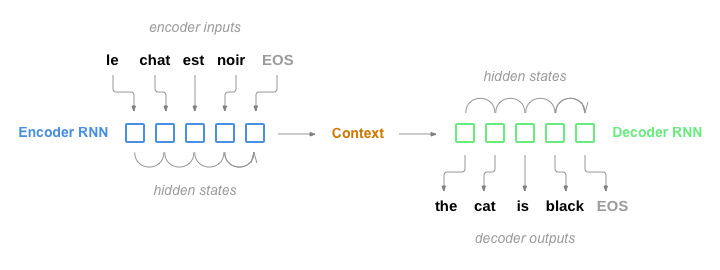

Reference: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb

Define the encoder and decoder

In [17]:
# Encoder

# defines a Python class named EncoderRNN,
# which is a subclass of nn.Module
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size): # It takes two arguments
        # input_size: The size of the input vocabulary,
        # which represents the number of unique tokens in the input data.
        # hidden_size: The size of the hidden state of the GRU
        # (Gated Recurrent Unit) layer in the encoder.

        # creates an embedding layer (nn.Embedding) within the encoder
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # The GRU is a type of recurrent neural network (RNN) layer
        # used to process sequential data
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # input: a tensor representing a sequence of tokens
        # shape is expected to be (sequence_length, batch_size)
        # hidden: The initial hidden state of the GRU layer

        # It reshapes the embeddings to have a shape of (1, 1, -1),
        # where -1 means that the size is inferred based on the other dimensions.
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # initializes the hidden state of the encoder
        # It returns a tensor filled with zeros of shape (1, 1, hidden_size)
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
# Decoder

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        # hidden_size: The size of the hidden state of the GRU
        # output_size: The size of the output vocabulary

        super(DecoderRNN, self).__init__()
        # initialize the DecoderRNN class properly
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        # a log-softmax layer (nn.LogSoftmax) along the specified dimension (dim=1).
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # defines the forward pass of the decoder

        output = self.embedding(input).view(1, 1, -1)

        # (ReLU) activation function to the embeddings
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        # initializes the hidden state of the decoder
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
# Attention Decoder

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # The dropout probability used to prevent overfitting.

        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # defines a linear layer (nn.Linear) that computes attention scores.
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)

        # defines another linear layer that combines
        # the attention context vector with the decoder's input embedding
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

        # defines a dropout layer (nn.Dropout) to apply dropout
        # with the specified probability self.dropout_p to the embeddings.
        self.dropout = nn.Dropout(self.dropout_p)

        #The GRU is a type of recurrent neural network (RNN) layer used to process sequential data.
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)

        # defines a linear layer (nn.Linear) that maps the output of
        # the decoder to the size of the output vocabulary
        #produce the final prediction for the next token in the target sequence
        self.out = nn.Linear(self.hidden_size, self.output_size)


    # forward pass of the decoder
    # The input data, which is typically a token from the target sequence.
    # Its shape is expected to be (sequence_length, batch_size)
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

##### Training

The whole training process looks like this:

* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

In [14]:
# Preparing the training data to put into a nn model
# Three functions that are used for preprocessing and converting text data into tensors

def indexesFromSentence(lang, sentence):
    # it looks up its index in the lang object
    # The list of indices corresponding to the words in the sentence is returned as the output
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [15]:
# Training the model

teacher_forcing_ratio = 0.5
# Teacher forcing is a technique where, during training,
# the target sequence is used as input to the decoder instead of the model's own predictions.
# A value of 0.5 means that there's a 50% chance of using teacher forcing.

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # criterion: The loss function (e.g., cross-entropy loss).

    # initialization
    encoder_hidden = encoder.initHidden()
    # clears the gradients of the encoder's parameters
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # initializes a tensor encoder_outputs
    # to store the outputs of the encoder for each time step
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # runs a loop over the input sequence to encode it using the encoder
    for ei in range(input_length):
        # For each time step,
        # it calls the encoder with the input token and the current hidden state
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # initializes the input to the decoder with the "Start of Sentence" token (SOS_token)
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # initializes the decoder's hidden state with the final hidden state of the encoder
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # calculates the loss between the decoder output and the target tensor
            # at the current time step and adds it to the cumulative loss
            loss += criterion(decoder_output, target_tensor[di])

            # The decoder input for the next time step is set to
            # the corresponding token from the target sequence (teacher forcing)
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            # The decoder input for the next time step is set to
            # the token predicted by the decoder at the current time step.
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])

            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    # updates the encoder's parameters using the optimizer
    # (e.g., stochastic gradient descent or Adam)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

We call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.

In [16]:
# This is a helper function to print time elapsed and
# estimated time remaining given the current time and progress %.
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def trainIters(input_lang, output_lang, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)



# Polotting the result
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


##### Evaluation

There are no targets so we simply feed the decoder's predictions back to itself for each step.

Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder's attention outputs for display later.

In [26]:
def evaluate(input_lang, output_lang, encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


# Selects a specified number of sentence pairs randomly from a dataset and
# evaluates the translation model on these pairs.
def evaluateRandomly(input_lang, output_lang, encoder, decoder, n=10):
    # n (default 10): The number of sentence pairs to randomly select and evaluate.
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(input_lang, output_lang, encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')



##### Training and Visualization







In [21]:
# The resulting plot will be displayed directly
%matplotlib inline

Reading lines...
Read 135842 sentence pairs
Trimmed to 95170 sentence pairs
Counting words...
Counted words:
fra 16813
eng 10025
['joue t elle du piano ?', 'does she play the piano ?']
0m 9s (- 1m 22s) (500 10%) 5.5868
0m 17s (- 1m 10s) (1000 20%) 5.3619
0m 25s (- 1m 0s) (1500 30%) 4.9065
0m 33s (- 0m 50s) (2000 40%) 4.8183
0m 41s (- 0m 41s) (2500 50%) 4.7825
0m 49s (- 0m 33s) (3000 60%) 4.7469
0m 58s (- 0m 24s) (3500 70%) 4.7567
1m 8s (- 0m 17s) (4000 80%) 4.6888
1m 18s (- 0m 8s) (4500 90%) 4.6624
1m 27s (- 0m 0s) (5000 100%) 4.5807


<Figure size 640x480 with 0 Axes>

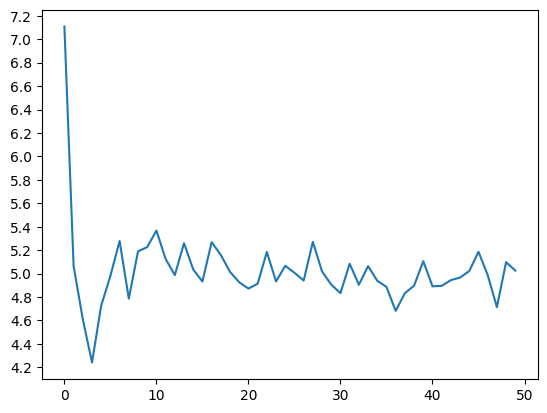

<Figure size 640x480 with 0 Axes>

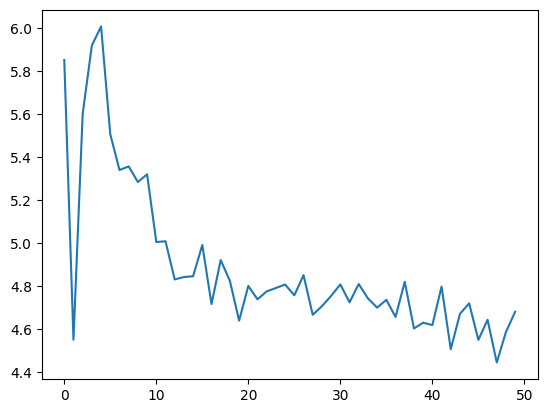

In [22]:
# Output is English

input_lang1, output_lang1, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

# Model Architecture
hidden_size = 20 # 256
encoder = EncoderRNN(input_lang1.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang1.n_words, dropout_p=0.1).to(device)

# Train the model
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(input_lang1, output_lang1, encoder, attn_decoder, 5000, print_every=500)

In [27]:
evaluateRandomly(input_lang1, output_lang1, encoder, attn_decoder)

> est ce vraiment si terrible ?
= is it really so terrible ?
< you you you you ? <EOS>

> elle a peint le mur en rouge .
= she painted the wall red .
< i m to . . <EOS>

> je suis enrhume .
= i ve got a cold .
< i m to . <EOS>

> personne ne put resoudre le casse tete .
= no one could solve the puzzle .
< i m you to . . <EOS>

> arrete ton char .
= come off it .
< i m to . <EOS>

> tom a appris a lire a marie .
= tom taught mary to read .
< i m to . . <EOS>

> nous voulons faire un simple changement .
= we want to make a simple change .
< i m to . . <EOS>

> aimerais tu cela ?
= would you like that ?
< you you you ? ? <EOS>

> elles ne peuvent m entendre non plus .
= they can t hear me either .
< i m to . . <EOS>

> elle va a l ecole .
= she goes to school .
< i m to . . <EOS>



['i', 'is', 'to', '.', '<EOS>']


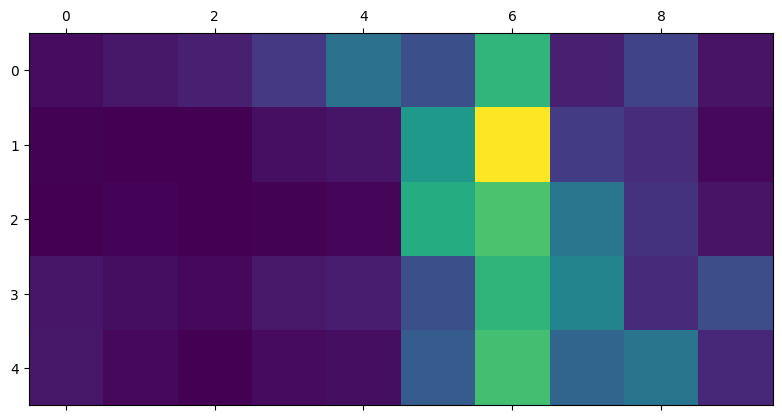

In [28]:
output_words, attentions = evaluate(
    input_lang1, output_lang1,
    encoder, attn_decoder, "je suis trop froid")

print(output_words)
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = i s to . . <EOS>
input = elle est trop petit .
output = i m to . <EOS>
input = je ne crains pas de mourir .
output = i m you to . <EOS>


<ipython-input-30-00c220bd4df1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-30-00c220bd4df1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


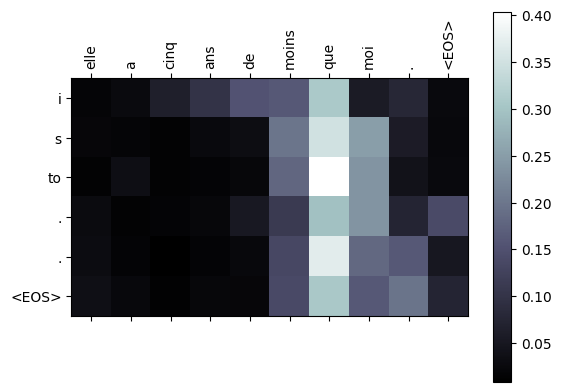

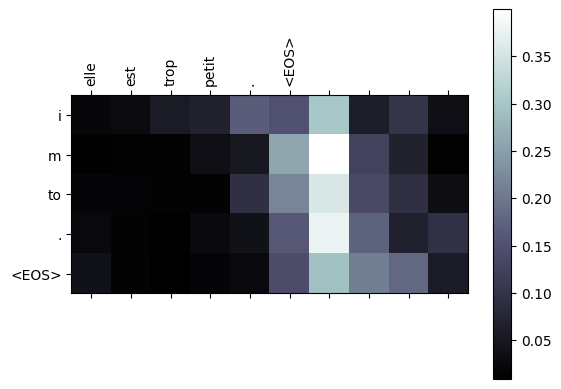

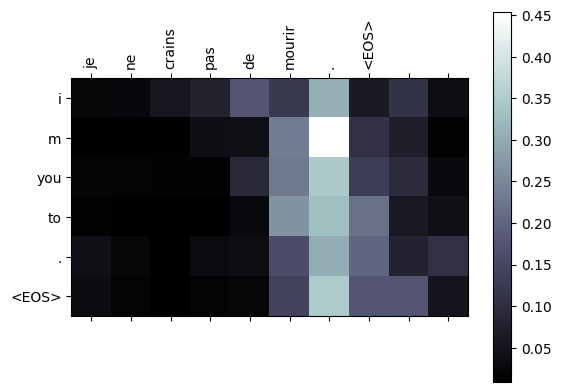

In [30]:
# EVALUATE ON TEST SENTENCES

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    #### remove to show plots
    #plt.show()


def evaluateAndShowAttention(input_lang, output_lang, input_sentence):
    input_sentenceR = input_sentence.translate(str.maketrans('', '', string.punctuation)).lower()
    output_words, attentions = evaluate(
        input_lang, output_lang,
        encoder, attn_decoder, input_sentenceR)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention(input_lang1, output_lang1, "elle a cinq ans de moins que moi .")
evaluateAndShowAttention(input_lang1, output_lang1, "elle est trop petit .")
evaluateAndShowAttention(input_lang1, output_lang1, "je ne crains pas de mourir .")

#### 2-2. English to Korean Model
 -  Reverse Model: Now train another model (Model 2) for the reverse (i.e., from English to the language you chose).

In [20]:
# Output is French (needed to be updated with Korean data)
input_lang2, output_lang2, pairs = prepareData('eng', 'fra', False)
print(random.choice(pairs))

# Model Architecture
hidden_size = 20 # 256
encoder = EncoderRNN(input_lang2.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang2.n_words, dropout_p=0.1).to(device)

# Train the model
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
trainIters(input_lang2, output_lang2, encoder, attn_decoder, 5000, print_every=500)

0m 8s (- 1m 12s) (500 10%) 5.1508
0m 15s (- 1m 3s) (1000 20%) 5.0923
0m 22s (- 0m 53s) (1500 30%) 5.1548
0m 30s (- 0m 46s) (2000 40%) 5.0601
0m 39s (- 0m 39s) (2500 50%) 4.9940
0m 47s (- 0m 31s) (3000 60%) 5.0284
0m 59s (- 0m 25s) (3500 70%) 4.9649
1m 8s (- 0m 17s) (4000 80%) 4.8808
1m 16s (- 0m 8s) (4500 90%) 4.9440
1m 24s (- 0m 0s) (5000 100%) 5.0023


 -  GloVe 100d embeddings: In this model, use the GloVe 100 dimensional embeddings. See notebook 4, cell 2 for an [example](https://github.com/bentrevett/pytorch-sentiment-analysis) while training.

In [31]:
import torchtext.vocab
glove = torchtext.vocab.GloVe(name = '6B', dim = 100)
print(f'There are {len(glove.itos)} words in the vocabulary')

.vector_cache/glove.6B.zip: 862MB [02:42, 5.31MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18281.70it/s]


There are 400000 words in the vocabulary


In [36]:
# dimensions of vectors
print(glove.vectors.shape)

# top 10 words
print(glove.itos[:10])

torch.Size([400000, 100])

In [68]:
# Import necessary libraries
import numpy as np

# Define a function to get word embeddings from GloVe
def get_embedding(word):
    return glove.vectors[glove.stoi[word]]

# From the list of pairs containing (English, Translation) pairs
# get a list of English words:
english_words = [pair[0] for pair in pairs]

# Create a vocabulary from the English words.
# We'll split the English sentences into words and collect unique words.
# Use a set to ensure uniqueness

english_vocabulary = set()
for sentence in english_words:
    words = sentence.split()
    english_vocabulary.update(words)

# Convert the set to a list to have an ordered vocabulary
english_vocabulary = list(english_vocabulary)

# Print the number of unique English words and some examples
print('Number of unique English words in our corpus:', len(english_vocabulary))
print('Some examples are', english_vocabulary[3000:3500])

Number of unique English words in our corpus: 10022
Some examples are ['discouraged', 'hasty', 'employment', 'willkie', 'mesopotamia', 'dressing', 'swollen', 'earthy', 'honor', 'mr', 'cord', 'forward', 'markings', 'scratch', 'fault', 'naive', 'plastered', 'depending', 'copies', 'feller', 'rejoicing', 'paranoid', 'horseradish', 'improvement', 'casualties', 'applicable', 'pop', 'souvenirs', 'planting', 'kilo', 'abhor', 'aroused', 'climbs', 'opponent', 'flat', 'agency', 'apologies', 'dwell', 'tireless', 'screen', 'bolted', 'actress', 'wrote', 'overdue', 'wayside', 'shooed', 'interrupt', 'politeness', 'key', 'attention', 'skipped', 'unruly', 'arrival', 'dearly', 'muttering', 'hogwash', 'wartime', 'choices', 'shiver', 'ounces', 'landlord', 'appeared', 'representative', 'now', 'ago', 'pressure', 'cherry', 'board', 'historian', 'stab', 'conferences', 'forcing', 'jimmied', 'hurt', 'wagging', 'gaze', 'called', 'inappropriate', 'hired', 'released', 'reek', 'president', 'respects', 'straightforwa

In [69]:
# Get GloVe embeddings for the words in the English vocabulary:
emb_dim = len(glove.vectors[0])  # Dimension of GloVe embeddings
weights_matrix = np.zeros((len(english_vocabulary), emb_dim))

for i, word in enumerate(english_vocabulary):
    try:
        # Get the GloVe embedding for each word
        weights_matrix[i] = get_embedding(word)
    except KeyError:
        # Handle missing words by initializing with a random vector or zeros
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))

In [74]:
# Define a function to get word embeddings from GloVe
def get_embedding_glove(word):
    return glove.vectors[glove.stoi[word]]

# Get a list of all english words in our dataset
print("Number of pairs, or translated phrases, is:", len(pairs))
eng_words = [el[0] for el in pairs]
a = []
for word in eng_words:
  a += word.split()
eng_vocabulary = list(set(a))
print('Number of unique English words in our corpus:', len(eng_vocabulary))
print('Some examples are', eng_vocabulary[3000:3500])

Number of pairs, or translated phrases, is: 95170
Number of unique English words in our corpus: 10022
Some examples are ['discouraged', 'hasty', 'employment', 'willkie', 'mesopotamia', 'dressing', 'swollen', 'earthy', 'honor', 'mr', 'cord', 'forward', 'markings', 'scratch', 'fault', 'naive', 'plastered', 'depending', 'copies', 'feller', 'rejoicing', 'paranoid', 'horseradish', 'improvement', 'casualties', 'applicable', 'pop', 'souvenirs', 'planting', 'kilo', 'abhor', 'aroused', 'climbs', 'opponent', 'flat', 'agency', 'apologies', 'dwell', 'tireless', 'screen', 'bolted', 'actress', 'wrote', 'overdue', 'wayside', 'shooed', 'interrupt', 'politeness', 'key', 'attention', 'skipped', 'unruly', 'arrival', 'dearly', 'muttering', 'hogwash', 'wartime', 'choices', 'shiver', 'ounces', 'landlord', 'appeared', 'representative', 'now', 'ago', 'pressure', 'cherry', 'board', 'historian', 'stab', 'conferences', 'forcing', 'jimmied', 'hurt', 'wagging', 'gaze', 'called', 'inappropriate', 'hired', 'released

We must build a matrix of weights that will be loaded into the PyTorch embedding layer. Its shape will be equal to:
(dataset’s vocabulary length, word vectors dimension).
For each word in dataset’s vocabulary, we check if it is on GloVe’s vocabulary. If it do it, we load its pre-trained word vector. Otherwise, we initialize a random vector.

In [78]:
# Define the dimension of the GloVe embeddings
emb_dim = 100

# Get the number of words in vocabulary
# matrix_len = len(input_lang2.word2index)
matrix_len = input_lang2.n_words

# Initialize the weight matrix with zeros
weights_matrix = np.zeros((matrix_len, emb_dim))

# Counter for tracking the number of words with embeddings found
words_found = 0

# Loop through each word in your vocabulary
for i, word in enumerate(input_lang2.word2index.keys()):
    try:
        # Try to get the GloVe embedding for the word
        weights_matrix[i] = get_embedding_glove(word)
        words_found += 1
    except KeyError:
        # If the word is not found in the GloVe embeddings, initialize it with a random vector
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))


print(weights_matrix.shape)

(10025, 100)

0m 8s (- 1m 15s) (500 10%) 5.4961
0m 18s (- 1m 13s) (1000 20%) 4.9489
0m 27s (- 1m 4s) (1500 30%) 4.7166
0m 37s (- 0m 56s) (2000 40%) 4.8325
0m 54s (- 0m 54s) (2500 50%) 4.6422
1m 6s (- 0m 44s) (3000 60%) 4.5875
1m 16s (- 0m 32s) (3500 70%) 4.5434
1m 27s (- 0m 21s) (4000 80%) 4.4831
1m 37s (- 0m 10s) (4500 90%) 4.3877
1m 46s (- 0m 0s) (5000 100%) 4.4602


<Figure size 640x480 with 0 Axes>

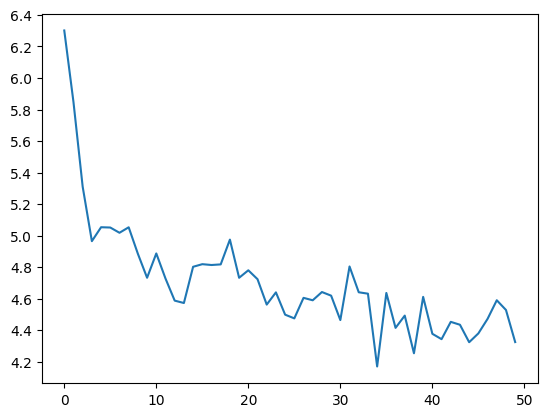

In [80]:
# Set a flag 'glove_model' to True if you want to use pre-trained GloVe embeddings
glove_model = True

# Define the hidden size for the model
hidden_size = 100

# Create an embedding layer
embedding = nn.Embedding(input_lang2.n_words, hidden_size)

# If 'glove_model' is True, initialize the embedding layer with pre-trained GloVe embeddings
if glove_model:
    embedding.weight.data.copy_(torch.from_numpy(weights_matrix))

# Create an encoder and an attention-based decoder
encoder2 = EncoderRNN(input_lang2.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang2.n_words, dropout_p=0.1).to(device)

# TRAIN MODEL
# Assuming 'trainIters' is a function that trains the model
trainIters(input_lang2, output_lang2,
           encoder2, attn_decoder2, 5000, print_every=500, learning_rate=0.1)


> that couldn t be helped .
= on n y pouvait rien .
< n est pas pas pas . <EOS>

> everyone has their own style .
= chacun a son propre style .
< je les les pas le . <EOS>

> let s be clear on this .
= soyons clairs quant a ceci !
< c est un un . <EOS>

> that s why i called you .
= c est pourquoi je t ai appele .
< je me un un . <EOS>

> where did you learn french ?
= ou avez vous appris le francais ?
< peux tu ce ? ? ? ? ? ? ?

> we ve been warned .
= on nous a avertis .
< nous nous nous nous nous . . <EOS>

> are you looking for someone ?
= tu cherches quelqu un ?
< avez avez ? ? ? ? ? ? ? <EOS>

> luckily i won first prize .
= heureusement j ai gagne le premier prix .
< je me pas . . <EOS>

> it s pitch black outside .
= il fait noir comme dans un four dehors .
< c est un . <EOS>

> could you show me that necktie ?
= pourriez vous me montrer cette cravate ?
< peux tu tu ? ? ? ? ? ? ?

input = I am walking to the store.
output = aide votre detends ! ! <EOS>


<ipython-input-30-00c220bd4df1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-30-00c220bd4df1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


input = This dinner is delicious.
output = aide rouler detends ! <EOS>
input = My mother lived in a white house.
output = aide votre on detends ! ! <EOS>
input = He has three friends.
output = on on on essaye <EOS>
input = I love good red wine.
output = aide rouler on detends ! <EOS>


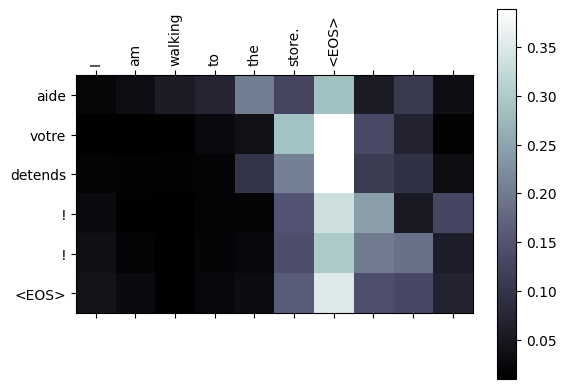

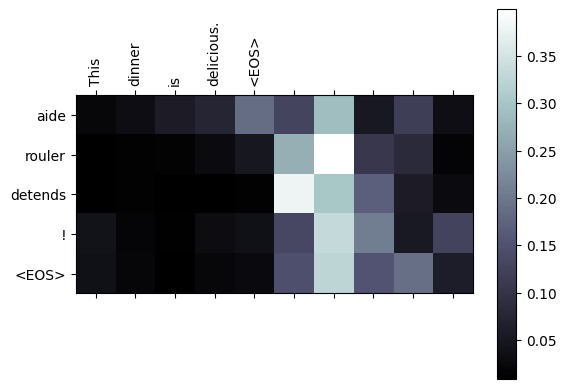

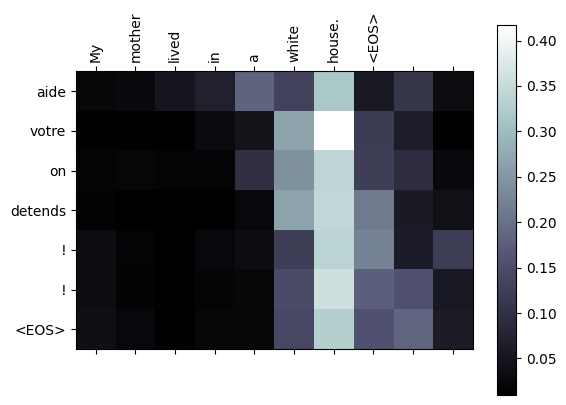

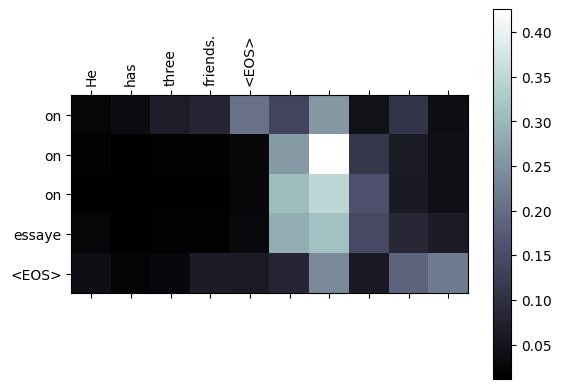

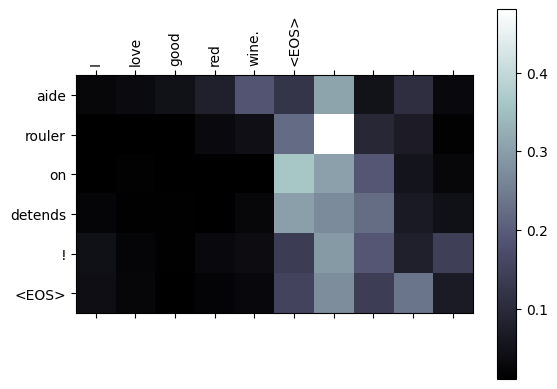

In [67]:
# EVALUATE
evaluateRandomly(input_lang2, output_lang2, encoder2, attn_decoder2)

# TEST ON FIVE SENTENCES
evaluateAndShowAttention(input_lang2, output_lang2, "I am walking to the store.")
evaluateAndShowAttention(input_lang2, output_lang2, "This dinner is delicious.")
evaluateAndShowAttention(input_lang2, output_lang2, "My mother lived in a white house.")
evaluateAndShowAttention(input_lang2, output_lang2, "He has three friends.")
evaluateAndShowAttention(input_lang2, output_lang2, "I love good red wine.")


#### 2-3. Compare outputs
 -  Input 5 well formed sentences from the English vocab to Model 2, and input the resultant translated sentences to Model 1. Display all model outputs in each case.

In [105]:
# Run Model 2 (English to Korean Glove model) to generate Korean sentence
# Set a flag 'glove_model' to True if you want to use pre-trained GloVe embeddings
glove_model = True

# Input sentence in English
input_sentence = random.choice(pairs)[0]
print('Original input sentence before translation:', input_sentence)

# Evaluate the input sentence using the pre-trained model
output_words2, attentions2 = evaluate(input_lang2, output_lang2,
                                      encoder2, attn_decoder2, input_sentence)

# Remove the end-of-sentence token from the generated output
output_words2 = output_words2[:-1]

# Join the output words into a single sentence
output_sentence_m2 = " ".join(output_words2)

# Print the English to Korean translation
print('English to Korean translation:', output_sentence_m2)


Original input sentence before translation: she apologized to him for being late .
English to Korean translation: elle a a de


In [106]:
# Run Model 1 generate English sentence

# Set a flag 'glove_model' to True if you want to use pre-trained GloVe embeddings
glove_model = False

# Input sentence in English
# input_sentence = output_sentence_m2

# Evaluate the input sentence using the pre-trained model
output_words1, attentions1 = evaluate(input_lang1, output_lang1,
                                      encoder, attn_decoder, output_sentence_m2)

# Remove the end-of-sentence token from the generated output
output_words1 = output_words1[:-1]

# Join the output words into a single sentence
output_sentence_m2_m1 = " ".join(output_words1)

# Print the English to Korean translation
print('Korean back to English translation:', output_sentence_m2_m1)


Korean back to English translation: i is to .
